# Advanced Data Science for MPS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from load_data_common import load_data
import seaborn as sns
import math

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.facecolor'] = 'white'

## Import MPS data

In [5]:
df_features, df_traces = load_data()
print(f"Number of samples: {df_features.shape[0]}")

Number of samples: 484


Let's look at the columns in our data

In [ ]:
print(df_features.columns)

## Format data for analysis

We need to change features into a form that represents the relative change for a given dose

$$f^{*}_d = \frac{f_d}{f_{d=0}}$$

We will limit our choice of features to a subset.


In [ ]:
features_of_interest = ['voltage_apd30', 'voltage_apd50', 'voltage_apd80', 'voltage_apd90',
                       'calcium_apd30', 'calcium_apd50', 'calcium_apd80', 'calcium_apd90',
                       'brightfield_Max contraction velocity [μm/s]', 'brightfield_Max relaxation velocity [μm/s]',
                       'brightfield_Time between contraction and relaxation [ms]',
                       'brightfield_Width at half height (displacement)[ms]']

# find unique rows based on columns
filter_names = ["drug", "well", "tissue"]
dff = df_features[filter_names].drop_duplicates()

df_norm = df_features.copy()

idxs_drop = []
for row in dff.itertuples():
    idxs = np.where((df_norm["drug"] == row.drug) & (df_norm["well"] == row.well) & (df_norm["tissue"] == row.tissue))[0]
    try:
        idx_bl = np.where((df_norm["drug"]==row.drug) & (df_norm["well"]==row.well) & (df_norm["tissue"]==row.tissue) & (df_norm["dose"]=="baseline"))
        a = df_norm[features_of_interest].iloc[idxs].values   # dosed values
        b = df_norm[features_of_interest].iloc[idx_bl].values # baseline values
        df_norm.loc[idxs, features_of_interest] = np.divide(a, b)
    except:
        for i in idxs: idxs_drop.append(i)
        continue
df_norm.drop(idxs_drop, inplace=True)
df_norm.reset_index(drop=True, inplace=True)


## Import drug summary table

Each drug will be treated as a class, with a corresponding mechanism of action that we will code as integer labels 0, 1, 2, ...

In [13]:
drug_mechanism = {
    "omecamtiv":"TnC agonist",
    "Nifedipine":"L-type Ca block",
    "Verapamil":"L-type Ca block, hERG block",
    "Bay_K":"L-type Ca block",
    "Dofetilide":"hERG block",
    "Flecainide":"Fast Na block, hERG block, RyR block",
    "Digoxin":"Na-K ATPase",
    "dobutamine":"beta adrenergic blocker",
    "carvedilol":"beta adrenergic blocker",
    "blebbistatin":"myosin ATPase blocker",
    "levosimendan":"potassium modulation, TnC agonist",
    "milrinone":"beta adrenergic agonist",
    "Isoproterenol":"beta adrenergic agonist",
    "Alfuzosin":"alpha adrenergic block",
    "Bepridil":"multi channel block",
    "Cisapride":"hERG block",
    "Terfenadine":"H1 receptor agonist",
    "Control":"NA", 
    "aspirin":"NA"
}

mechanism_list = list(set(drug_mechanism.values()))
mechanism_class = {
    mech:idx for mech,idx in zip(mechanism_list, range(len(mechanism_list)))
}
print(f"Number of unique drug classes = {len(mechanism_class)}")

Number of unique drug classes = 14


Let's check that the drugs in our data are listed in drug_mechanism

In [14]:
data_drugs = list(set(df_features.drug))
check = np.any([d not in drug_mechanism for d in data_drugs])
if check:
    print("Oops! Some drugs from data are not in the drug mechanism list!")
else:
    print("Looks good! All drugs are in list.")

## Unsupervised clustering

The first analysis we will perform is to see how the data naturally clusters using a simple k-means clustering algorithm.  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

This algorithm "seeds" (i.e., places) a specified number of cluster centers and iteratively moves them based on a distance minimization process (minimizing a criterion known as the within-cluster sum-of-squares)

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

### Run k-means clustering

In [15]:
# my_features = ["dose_float", "voltage_apd30", "voltage_apd60", "voltage_apd80", "voltage_apd90"]
my_features = features_of_interest

df_X = df_norm[(df_norm["dose"]!="baseline")].dropna(inplace=False)
X = df_X.loc[:, my_features]
print(f"Number of data points = {len(X)}")

n_clusters = 14 # set to equal the number of drugs/mechanisms
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
X_tf = kmeans.transform(X)

Now we compare the real drug name and class of mechanism to the assigned cluster labels

In [16]:
drug_as_mechanism_class = [mechanism_class[drug_mechanism[d]] for d in df_X["drug"].values]
compare = [[d, mc, cc] for d,mc,cc in zip(df_X["drug"].values, drug_as_mechanism_class, kmeans.labels_)]

cluster_centers = kmeans.cluster_centers_
cluster_dist = {f"dist_c{i}":X_tf[:,i] for i in range(n_clusters)}

data = {"drug":df_X["drug"], 
        "mechanism":[drug_mechanism[d] for d in df_X["drug"].values],
        "mechanism_class":drug_as_mechanism_class,
        "kmeans_label":kmeans.labels_
       }
data = {**data, **cluster_dist}

df_kmeans = pd.DataFrame(data=data)

In [17]:
# Calculate distance between each cluster center
cluster_dist_2d = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cluster_dist_2d[i,j] = math.dist(cluster_centers[i], cluster_centers[j])

Plot the frequency of each cluster for each drug

<Axes: xlabel='kmeans_label', ylabel='drug'>

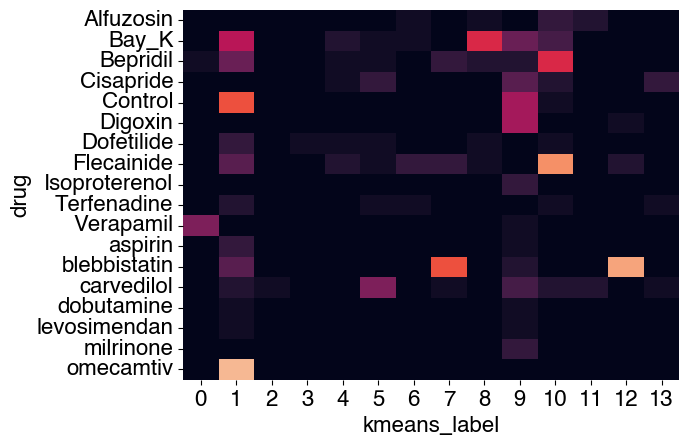

In [18]:
df_count = pd.crosstab(df_kmeans["drug"], df_kmeans["kmeans_label"])
sns.heatmap(data=df_count,
           vmin=0,
           vmax=22,
           xticklabels=True,
           yticklabels=True,
           cbar=False)

Plot the distance between each cluster center

In [ ]:
# Calculate distance between each cluster center
cluster_dist_2d = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cluster_dist_2d[i,j] = math.dist(cluster_centers[i], cluster_centers[j])
        
g = sns.heatmap(cluster_dist_2d)
g.set_xlabel("kmeans_label")
g.set_ylabel("kmeans_label")
g.set_title("Distance between kmeans clusters")

In [ ]:

plt.figure(figsize=(12,5))
g = sns.violinplot(data=df_kmeans,
                   x="drug",
                   y="kmeans_label",
                   scale="width",
                   bw=0.2
                   # hue="kmeans_label"
                 )
g.set_xticklabels(g.get_xticklabels(), rotation=45);

## Dimensionality reduction

In [ ]:
# Dim reduction here

# Exercise where different features are chosen for classification and 

## Supervised learning

Unsupervised clustering is a great way to identify groups in data in an unbiased way, the goal of which is to see if data is naturally separable in a meaningful way.

Supervised learning has a different goal: We seek to classify new data based on what we know about existing data.